In [1]:
import glob
import os
import pandas as pd
from io import StringIO
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')
import numpy as np
import matplotlib as mpl
import sys
mpl.rcParams.update(mpl.rcParamsDefault)

plt.rc('font', family='sans-serif')#, serif='Times')
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.rc('axes', labelsize=12)
plt.rc('legend', fontsize=11)
#plt.rcParams['mathtext.fontset'] = 'stix'
#plt.rcParams['font.family'] = 'STIXGeneral'
params = {
'text.usetex': True,
#'font.size': 15,
#'text.latex.unicode': True
}
plt.rcParams.update(params)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
DIR = '/cluster/home/mikhaika/metagenome/data/BIGSI/subsets/'

graph_size = []
graph_small_size = []
graph_faster_size = []
annotation_size_column = []
annotation_size_flat = []
annotation_size_brwt = []
annotation_size_brwt_relaxed = []
annotation_size_rbfish = []

for i in range(750, 24751, 750):
    graph_size.append(os.path.getsize(DIR + 'graph_subset_{}.dbg'.format(i))
                        + os.path.getsize(DIR + 'graph_subset_{}.edgemask'.format(i)))
    try:
        graph_small_size.append(os.path.getsize(DIR + 'graph_subset_{}.small.dbg'.format(i))
                                    + os.path.getsize(DIR + 'graph_subset_{}.small.edgemask'.format(i)))
    except:
        graph_small_size.append(np.nan)
    try:
        graph_faster_size.append(os.path.getsize(DIR + 'graph_subset_{}.faster.dbg'.format(i))
                                    + os.path.getsize(DIR + 'graph_subset_{}.faster.edgemask'.format(i)))
    except:
        graph_faster_size.append(np.nan)
    try:
        annotation_size_column.append(os.path.getsize(DIR + 'annotation_subset_{}.column.annodbg'.format(i)))
    except:
        annotation_size_column.append(np.nan)
    try:
        annotation_size_flat.append(os.path.getsize(DIR + 'annotation_subset_{}.flat.annodbg'.format(i)))
    except:
        annotation_size_flat.append(np.nan)
    try:
        annotation_size_brwt.append(os.path.getsize(DIR + 'annotation_subset_{}.brwt.annodbg'.format(i)))
    except:
        annotation_size_brwt.append(np.nan)
    try:
        annotation_size_brwt_relaxed.append(os.path.getsize(DIR + 'annotation_subset_{}.relaxed.brwt.annodbg'.format(i)))
    except:
        annotation_size_brwt_relaxed.append(np.nan)
    try:
        annotation_size_rbfish.append(os.path.getsize(DIR + 'annotation_subset_{}.rbfish.annodbg'.format(i)))
    except:
        annotation_size_rbfish.append(np.nan)

results = pd.DataFrame(columns=['n_samples', 'graph', 'graph_small', 'graph_faster',
                                'anno_column', 'anno_flat',
                                'anno_brwt', 'anno_brwt_relaxed',
                                'anno_rbfish'],
                       data=zip(list(range(750, 24751, 750)),
                                graph_size,
                                graph_small_size,
                                graph_faster_size,
                                annotation_size_column,
                                annotation_size_flat,
                                annotation_size_brwt,
                                annotation_size_brwt_relaxed,
                                annotation_size_rbfish))
results.shape[0]

33

In [3]:
bloom_size = []

for i in range(750, 24751, 750):
    files = !cat subsets/files_{i}.txt
    ids = [f.split('/')[-1].split('.')[0] for f in files]
    try:
        bloom_size.append(sum([os.path.getsize(DIR + 'bigsi/bloom/{}.bloom'.format(x)) for x in ids]))
    except:
        bloom_size.append(np.nan)

results['bigsi_bloom'] = bloom_size

In [4]:
bigsi_size = []

for i in range(750, 24751, 750):
    try:
        bigsi_size.append(os.path.getsize(DIR + 'bigsi/subsets/index_{}/combined-index'.format(i)))
    except:
        bigsi_size.append(np.nan)

results['bigsi_db'] = bigsi_size

In [5]:
for (h, fpr) in [#(1, 30),
                 #(1, 10), (3, 10),
                 #(1, 5), (2, 5), (3, 5), (4, 5),
                 #(1, 1), (2, 1), (3, 1), (4, 1), (5, 1),
                 (3, 10), (4, 5), (7, 1)]:
    cobs_size = []

    for i in range(750, 24751, 750):
        try:
            cobs_size.append(os.path.getsize(DIR + 'cobs/cobs_index_h{}_fpr{}_{}.cobs_compact'.format(h, fpr, i)))
        except:
            cobs_size.append(np.nan)

    results['cobs_h{}_fpr{}'.format(h, fpr)] = cobs_size

In [6]:
mantis_size = []
mantis_rrr_size = []
mantis_mst_size = []

for i in range(750, 24751, 750):
    try:
        mantis_size.append(os.path.getsize(DIR + 'mantis/cqfs/files_{}/dbg_cqf.ser'.format(i)))

        files = !find {DIR}mantis/cqfs/files_{i}/ -name *eqclass_rrr.cls
        if len(files):
            mantis_rrr_size.append(sum([os.path.getsize(f) for f in files]))
        else:
            mantis_rrr_size.append(np.nan)

        files = !find {DIR}mantis/cqfs/files_{i}/ -name *.bv
        if len(files) == 3:
            mantis_mst_size.append(sum([os.path.getsize(f) for f in files]))
        else:
            mantis_mst_size.append(np.nan)
    except:
        mantis_size.append(np.nan)
        mantis_rrr_size.append(np.nan)
        mantis_mst_size.append(np.nan)

results['mantis_index'] = mantis_size
results['mantis_rrr'] = mantis_rrr_size
results['mantis_mst'] = mantis_mst_size

In [7]:
#results.loc[range(17, 20), 'mantis_rrr'] = np.nan
#results.loc[range(17, 20), 'mantis_mst'] = np.nan

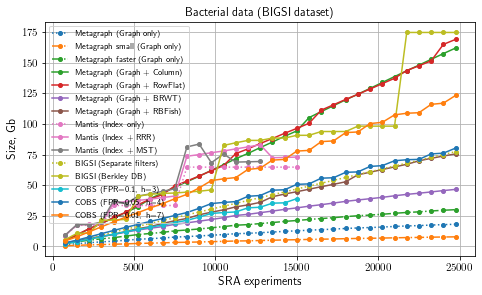

In [8]:
width = 3.487 * 1.5 * 1.3
height = width / 1.618

fig, axes = plt.subplots(1, 1, figsize=(width, height))
#ax.set_title('RefSeq assembly graph')

# results.sort_values('num_kmers', inplace=True)

# colors = ['c', 'b', 'g', 'r']

ax = axes

lines = ax.plot(results.n_samples,
                results.graph / 10**9,
                marker='o', ms=4, label='Metagraph (Graph only)', linestyle=':')

lines = ax.plot(results.n_samples,
                results.graph_small / 10**9,
                marker='o', ms=4, label='Metagraph small (Graph only)', linestyle='-.')

lines = ax.plot(results.n_samples,
                results.graph_faster / 10**9,
                marker='o', ms=4, label='Metagraph faster (Graph only)', linestyle='-.')

ax.plot(results.n_samples,
        (results.graph + results.anno_column) / 10**9,
        marker='o', ms=4, label='Metagraph (Graph + Column)', color=lines[0].get_color())

ax.plot(results.n_samples,
        (results.graph + results.anno_flat) / 10**9,
        marker='o', ms=4, label='Metagraph (Graph + RowFlat)')

ax.plot(results.n_samples,
        (results.graph + results.anno_brwt) / 10**9,
        marker='o', ms=4, label='Metagraph (Graph + BRWT)')

ax.plot(results.n_samples,
        (results.graph + results.anno_rbfish) / 10**9,
        marker='o', ms=4, label='Metagraph (Graph + RBFish)')


lines = ax.plot(results.n_samples,
                results.mantis_index / 10**9,
                marker='o', ms=4, label='Mantis (Index only)', linestyle=':')

ax.plot(results.n_samples,
        (results.mantis_index + results.mantis_rrr) / 10**9,
        marker='o', ms=4, label='Mantis (Index + RRR)', color=lines[0].get_color())

ax.plot(results.n_samples,
        (results.mantis_index + results.mantis_mst) / 10**9,
        marker='o', ms=4, label='Mantis (Index + MST)')


lines = ax.plot(results.n_samples,
                results.bigsi_bloom / 10**9,
                marker='o', ms=4, label='BIGSI (Separate filters)', linestyle=':')

ax.plot(results.n_samples, results.bigsi_db / 10**9,
        marker='o', ms=4, label='BIGSI (Berkley DB)', color=lines[0].get_color())


# ax.plot(results.n_samples, results.cobs_h1_fpr30 / 10**9,
#         marker='o', ms=4, label='COBS (FPR=0.3, h=1)')

for (h, fpr) in [#(1, 30),
                 #(1, 10), (3, 10),
                 #(1, 5), (2, 5), (3, 5), (4, 5),
                 #(1, 1), (2, 1), (3, 1), (4, 1), (5, 1)
                 (3, 10), (4, 5), (7, 1)]:
    ax.plot(results.n_samples, results['cobs_h{}_fpr{}'.format(h, fpr)] / 10**9,
            marker='o', ms=4, label='COBS (FPR={}, h={})'.format(fpr / 100, h))

ax.set_title('Bacterial data (BIGSI dataset)')
ax.set_xlabel('SRA experiments')
ax.set_ylabel('Size, Gb')
#     ax.set_xlim([-1e9, 25e9])
#ax.set_xticks(np.array(k_array))
ax.grid(True)
#     ax.legend(loc='best')

legend = ax.legend(loc="best", fontsize=8)
legend.get_frame().set_facecolor('none')
# plt.ylim([-5, 110])
# axes[1].set_ylim([-1e-1, 75])
# plt.yscale('symlog')

plt.tight_layout()
plt.savefig('graph_scalability_all.pdf', format='pdf', bbox_inches='tight')
plt.show()

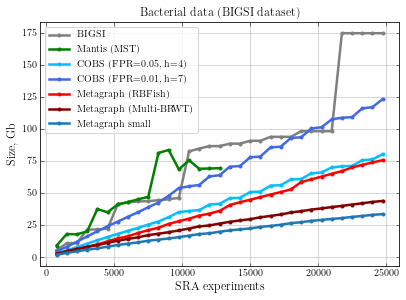

In [9]:
width = 3.487 * 1.5 * 1.1
height = width / 1.618 * 1.2

plt.rc('font', family='serif')#, serif='Times')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=12)
plt.rc('legend', fontsize=10)
#plt.rcParams['mathtext.fontset'] = 'stix'
#plt.rcParams['font.family'] = 'STIXGeneral'
params = {
'text.usetex': True,
#'font.size': 15,
#'text.latex.unicode': True
}
plt.rcParams.update(params)

fig, axes = plt.subplots(1, 1, figsize=(width, height))
#ax.set_title('RefSeq assembly graph')

# results.sort_values('num_kmers', inplace=True)

# colors = ['c', 'b', 'g', 'r']

ax = axes

# lines = ax.plot(results.n_samples,
#                 results.mantis_index / 10**9,
#                 marker='o', ms=4, label='Mantis (CQF only)', linestyle=':', color='g')

# ax.plot(results.n_samples,
#         (results.mantis_index + results.mantis_rrr) / 10**9,
#         marker='o', ms=4, label='Mantis', color=lines[0].get_color())

ax.plot(results.n_samples, results.bigsi_db / 10**9,
        marker='o', ms=3, linewidth=2.5, label='BIGSI', color='grey')

ax.plot(results.n_samples,
        (results.mantis_index + results.mantis_mst) / 10**9,
        marker='o', ms=3, linewidth=2.5, label='Mantis (MST)', color='g')

h, fpr = (4, 5)
ax.plot(results.n_samples, results['cobs_h{}_fpr{}'.format(h, fpr)] / 10**9,
        marker='o', ms=3, linewidth=2.5, label='COBS (FPR={}, h={})'.format(fpr / 100, h), color='deepskyblue')
h, fpr = (7, 1)
ax.plot(results.n_samples, results['cobs_h{}_fpr{}'.format(h, fpr)] / 10**9,
        marker='o', ms=3, linewidth=2.5, label='COBS (FPR={}, h={})'.format(fpr / 100, h), color='royalblue')

ax.plot(results.n_samples,
        (results.graph + results.anno_rbfish) / 10**9,
        marker='o', ms=3, linewidth=2.5, label='Metagraph (RBFish)', color='red')

ax.plot(results.n_samples,
        (results.graph + results.anno_brwt_relaxed) / 10**9,
        marker='o', ms=3, linewidth=2.5, label='Metagraph (Multi-BRWT)', color='maroon')

ax.plot(results.n_samples,
        (results.graph_small + results.anno_brwt_relaxed) / 10**9,
        marker='o', ms=3, linewidth=2.5, label='Metagraph small')


ax.set_title('Bacterial data (BIGSI dataset)')
ax.set_xlabel('SRA experiments')
ax.set_ylabel('Size, Gb')
ax.tick_params(reset=True, direction='in', which='both', bottom=True, top=True, left=True, right=True, width=0.5)
ax.grid(True, linewidth=0.5)
#     ax.set_xlim([-1e9, 25e9])
#ax.set_xticks(np.array(k_array))
#     ax.legend(loc='best')

legend = ax.legend(loc="best", fontsize=10)
#legend.get_frame().set_facecolor('none')
#ax.set_yscale('log')
# plt.ylim([-5, 110])
#plt.xlim([0, 50000])
# axes[1].set_ylim([-1e-1, 75])
# plt.yscale('symlog')

plt.tight_layout()
plt.savefig('graph_scalability.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Query time

In [10]:
plt.rc('font', family='serif')#, serif='Times')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=12)
plt.rc('legend', fontsize=10)
#plt.rcParams['mathtext.fontset'] = 'stix'
#plt.rcParams['font.family'] = 'STIXGeneral'
params = {
'text.usetex': False,
#'font.size': 15,
#'text.latex.unicode': True
}
plt.rcParams.update(params)

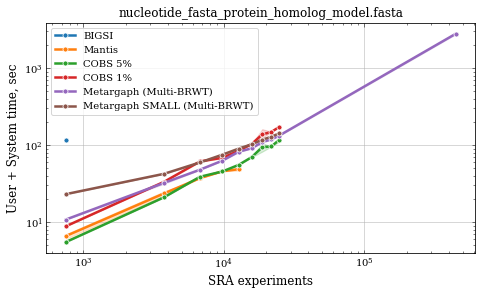

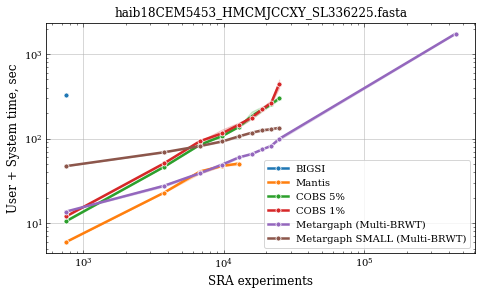

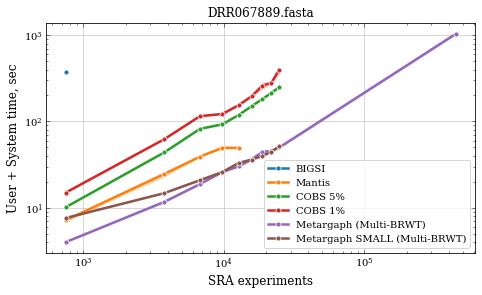

In [15]:
import re
import seaborn as sns

def parse_time_from_logs(log_files):
    table = pd.DataFrame(columns=['n_samples', 'total_time'])
    for log_file in log_files:
        try:
            lines_user = !grep "User time (seconds):" $log_file
            lines_system = !grep "System time (seconds):" $log_file
            assert(len(lines_user) == len(lines_system))
            for line_user, line_system in zip(lines_user, lines_system):
                query_time = float(re.search('User time \(seconds\): ([0-9\.]*)', line_user).group(1))
                query_time += float(re.search('System time \(seconds\): ([0-9\.]*)', line_system).group(1))
                table = table.append([{'n_samples': int(log_file.split('/')[-1].split('.')[-2]),
                               'total_time': query_time}])
        except:
            pass

    return table

def plot_query_time(DIR, OTHER):
    results = {}
    results['BIGSI'] = parse_time_from_logs(glob.glob(OTHER + '/bigsi/*.err'))
    results['Mantis'] = parse_time_from_logs(glob.glob(OTHER + '/mantis.mst/*.err'))
    results['Mantis'].loc[results['Mantis']['n_samples'] > 14000] = np.nan
    results['COBS 5%'] = parse_time_from_logs(glob.glob(OTHER + '/cobs_index_h4_fpr5/*.err'))
    results['COBS 1%'] = parse_time_from_logs(glob.glob(OTHER + '/cobs_index_h7_fpr1/*.err'))
    results['COBS 1%'] = parse_time_from_logs(glob.glob(OTHER + '/cobs_index_h7_fpr1/*.err'))
    results['Metargaph (Multi-BRWT)'] = parse_time_from_logs(glob.glob(DIR + '/metagraph.stat.brwt_relax/*.err'))
    results['Metargaph SMALL (Multi-BRWT)'] = parse_time_from_logs(glob.glob(DIR + '/metagraph.small.brwt_relax/*.err'))
#    results['Metargaph NEW (Multi-BRWT)'] = parse_wall_time_from_logs(glob.glob(DIR + '/metagraph.stat.brwt_relax_new/*.err'))

    width = 3.487 * 1.5 * 1.3
    height = width / 1.618

    fig, axes = plt.subplots(1, 1, figsize=(width, height))
    ax = axes

    # colors = ['c', 'b', 'g', 'r']

    for name, table in results.items():
        table.sort_values('n_samples', inplace=True)
        x = table['n_samples']
        y = table['total_time']
#        x = results.index[~results[col].isna()]
#        y = results[col][~results[col].isna()]
        sns.lineplot(ax=ax, x='n_samples', y='total_time', data=table, marker='o', ms=5, linewidth=2.5, label=name)
#        ax.plot(x, y, marker='o', ms=3, linewidth=2.5, label=name)

    ax.set_title(DIR.split('/')[-1])
    ax.set_xlabel('SRA experiments')
    ax.set_ylabel('User + System time, sec')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.tick_params(reset=True, direction='in', which='both', bottom=True, top=True, left=True, right=True, width=0.5)
    ax.grid(True, linewidth=0.5)

    legend = ax.legend(loc="best", fontsize=10)

    plt.tight_layout()
    plt.savefig('query_time.pdf', format='pdf', bbox_inches='tight')
    plt.show()

plot_query_time('/cluster/home/mikhaika/metagenome/data/BIGSI/subsets/query_results/nucleotide_fasta_protein_homolog_model.fasta',
                '/cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/results/nucleotide_fasta_protein_homolog_model')
plot_query_time('/cluster/home/mikhaika/metagenome/data/BIGSI/subsets/query_results/haib18CEM5453_HMCMJCCXY_SL336225.fasta',
                '/cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/results/haib18CEM5453_HMCMJCCXY_SL336225')
plot_query_time('/cluster/home/mikhaika/metagenome/data/BIGSI/subsets/query_results/DRR067889.fasta',
                '/cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/results/DRR067889')

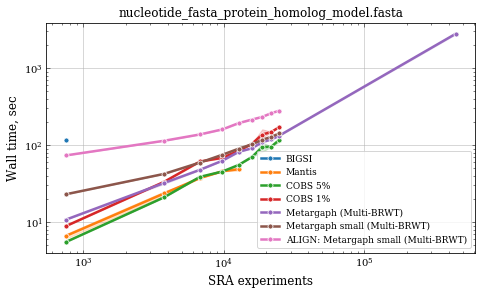

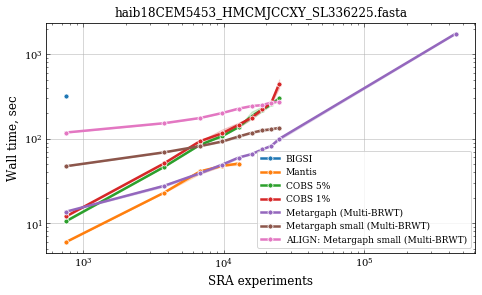

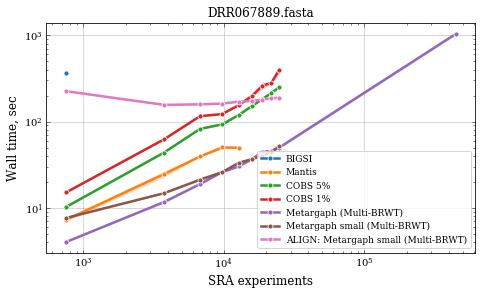

In [23]:
def parse_wall_time_from_logs(log_files):
    table = pd.DataFrame(columns=['n_samples', 'total_time'])
    for log_file in log_files:
        try:
            lines = !grep "time (h:mm:ss or m:ss):" $log_file
            lines_exit = !grep "Exit status:" $log_file
            assert(len(lines) == len(lines_exit))

            for line, line_exit in zip(lines, lines_exit):
                if int(re.search('Exit status: ([0-9]*)', line_exit).group(1)) != 0:
                    continue

                time_str = re.search('time \(h:mm:ss or m:ss\): ([0-9:\.]*)', line).group(1)
                query_time = 0
                for i, x in enumerate(time_str.split(':')[::-1]):
                    query_time += float(x) * 60**i

                table = table.append([{'n_samples': int(log_file.split('/')[-1].split('.')[-2]),
                               'total_time': query_time}])
        except:
            pass

    return table

def plot_query_time(DIR, OTHER):
    results = {}
    results['BIGSI'] = parse_wall_time_from_logs(glob.glob(OTHER + '/bigsi/*.err'))
    results['Mantis'] = parse_wall_time_from_logs(glob.glob(OTHER + '/mantis.mst/*.err'))
    results['COBS 5%'] = parse_wall_time_from_logs(glob.glob(OTHER + '/cobs_index_h4_fpr5/*.err'))
    results['COBS 1%'] = parse_wall_time_from_logs(glob.glob(OTHER + '/cobs_index_h7_fpr1/*.err'))
    results['COBS 1%'] = parse_wall_time_from_logs(glob.glob(OTHER + '/cobs_index_h7_fpr1/*.err'))
    results['Metargaph (Multi-BRWT)'] = parse_wall_time_from_logs(glob.glob(DIR + '/metagraph.stat.brwt_relax/*.err'))
    results['Metargaph small (Multi-BRWT)'] = parse_wall_time_from_logs(glob.glob(DIR + '/metagraph.small.brwt_relax/*.err'))
    results['ALIGN: Metargaph small (Multi-BRWT)'] = parse_wall_time_from_logs(glob.glob(OTHER + '/metagraph.small.align/*.err'))

    width = 3.487 * 1.5 * 1.3
    height = width / 1.618

    fig, axes = plt.subplots(1, 1, figsize=(width, height))
    ax = axes

    # colors = ['c', 'b', 'g', 'r']

    for name, table in results.items():
        table.sort_values('n_samples', inplace=True)
        x = table['n_samples']
        y = table['total_time']
#        x = results.index[~results[col].isna()]
#        y = results[col][~results[col].isna()]
        sns.lineplot(ax=ax, x='n_samples', y='total_time', data=table, marker='o', ms=5, linewidth=2.5, label=name)
#        ax.plot(x, y, marker='o', ms=3, linewidth=2.5, label=name)

    ax.set_title(DIR.split('/')[-1])
    ax.set_xlabel('SRA experiments')
    ax.set_ylabel('Wall time, sec')
    ax.set_yscale('log')
    ax.set_xscale('log')
#    ax.set_ylim([1, 150])
    ax.tick_params(reset=True, direction='in', which='both', bottom=True, top=True, left=True, right=True, width=0.5)
    ax.grid(True, linewidth=0.5)

    legend = ax.legend(loc="best", fontsize=9)

    plt.tight_layout()
    plt.savefig('query_time_wall_time_{}.pdf'.format(OTHER.split('/')[-1]), format='pdf', bbox_inches='tight')
    plt.show()

plot_query_time('/cluster/home/mikhaika/metagenome/data/BIGSI/subsets/query_results/nucleotide_fasta_protein_homolog_model.fasta',
                '/cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/results/nucleotide_fasta_protein_homolog_model')
plot_query_time('/cluster/home/mikhaika/metagenome/data/BIGSI/subsets/query_results/haib18CEM5453_HMCMJCCXY_SL336225.fasta',
                '/cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/results/haib18CEM5453_HMCMJCCXY_SL336225')
plot_query_time('/cluster/home/mikhaika/metagenome/data/BIGSI/subsets/query_results/DRR067889.fasta',
                '/cluster/work/grlab/projects/metagenome/data/BIGSI/subsets/query/results/DRR067889')